In [50]:
# IMPORTS
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sc
from scipy import linalg, optimize, constants, interpolate, special, stats
import math as ma
from math import exp, pow, sqrt, log
import seaborn as sns 
import statsmodels.api as sm
import statsmodels.stats.api as sms
import keras
import random
from keras.utils import plot_model, to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Conv1D, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD
import sklearn as sl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from prettytable import PrettyTable
from sklearn.decomposition import PCA

%matplotlib inline

# CNN 1D Modell

### Daten vorverarbeiten

In [51]:
# csv einlesen
Vein = pd.read_csv('datensatz/vein.csv')
# dataframe draus machen
df = pd.DataFrame(Vein)

#inputs und targets generieren (Spalte 1 für die Targets, Spalte 2 bis Ende für die Inputs)
inputs = df.iloc[1:, 2:].values
targets = df.iloc[1:, 1].values

#PCA VERSION 1

#Standardscaler über inputs laufen lassen 
scaler = StandardScaler()
scaler.fit(inputs)

# Apply transform to Inputs
scaled_inputs = scaler.transform(inputs)

# Make an instance of the Model
pca = PCA(20) # ODER: pca = PCA(n_components=20)

pca.fit(scaled_inputs)

inputs_pca = pca.transform(scaled_inputs)

print(inputs_pca.shape)

inputs = inputs_pca.reshape(inputs_pca.shape[0],1,20).astype( 'float32' )

print('Input Shape : ' , inputs.shape)
random.shuffle(inputs)
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size = 0.3)

print(inputs_train[0:2])

#(Anzahl Datenpunkte, Höhe, Breite, Kanäle)  
print('Training data shape : ', inputs_train.shape, targets_train.shape)
print('Testing data shape : ', inputs_test.shape, targets_test.shape)


print('\n-----------------')
#TARGETS
targets_train_categorial = to_categorical(targets_train)
targets_test_categorial = to_categorical(targets_test)

x = PrettyTable()
x.field_names = ["target", "!has_DM2", "has_DM2"]

i = 0
for target in targets_train_categorial:
    hasNotDM2, hasDM2 = target
    x.add_row([targets_train[i],hasNotDM2, hasDM2])
    i+=1
print(x)


(20, 20)
Input Shape :  (20, 1, 20)
[[[-7.4130280e+01  4.0593365e+01  4.9822754e-01 -2.7531046e-02
   -5.8336741e-01 -2.4195943e+00  1.3187851e+00 -5.9334701e-01
    8.5310906e-02 -4.1031593e-01 -3.2223862e-01 -1.9491850e-01
    9.4507165e-02 -2.6423542e-03 -1.1684977e-01  1.7061511e-01
   -1.7530863e+00  3.1732521e+00 -2.8081128e-01 -1.3075652e-13]]

 [[-2.8442493e+01 -6.4281960e+00  1.4821917e+00 -1.7861935e+00
    3.4358409e-01  2.0576408e+00  2.1444223e+00  1.3793089e+00
   -3.3531843e-03  2.3887031e+00 -1.6591390e+00  2.4387600e+00
    5.2924700e+00  1.4534475e-01 -3.0729668e+00 -6.7763168e-01
   -3.9948615e-01 -3.9931253e-01  8.4758531e-03 -4.1555301e-14]]]
Training data shape :  (14, 1, 20) (14,)
Testing data shape :  (6, 1, 20) (6,)

-----------------
+--------+----------+---------+
| target | !has_DM2 | has_DM2 |
+--------+----------+---------+
|  1.0   |   0.0    |   1.0   |
|  1.0   |   0.0    |   1.0   |
|  1.0   |   0.0    |   1.0   |
|  0.0   |   1.0    |   0.0   |
|  1.0

### Plotfunktion 

In [52]:
#Funktion für Plot Loss
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

# 2. CNN-Modell

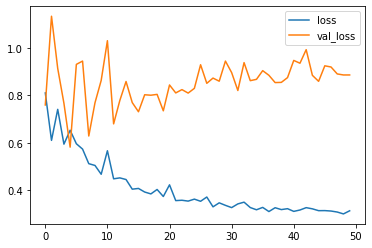

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_38 (Conv1D)           (None, 1, 32)             1312      
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 1, 32)             2080      
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 1, 16)             1040      
_________________________________________________________________
flatten_13 (Flatten)         (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 34        
Total params: 4,466
Trainable params: 4,466
Non-trainable params: 0
_________________________________________________________________
None
6/6 [==============================] - 0s 854us/step
Accuracy: 50.00


In [53]:
veinModel = Sequential()

veinModel.add(Conv1D(32,                #Anzahl der Filter
              kernel_size=2,        #Dimensionen des Fensters
              strides=1,            #Größe der Schritte
              padding='same',           #Padding: same=dim(in)=dim(out), valid=no Padding
              activation='relu',        #Aktivierungsfunktion
              input_shape=inputs_train[0].shape))   #Dimension des Inputs

veinModel.add(Conv1D(32, 
              kernel_size=2, 
              strides=1,            #Größe der Schritte
              padding='same',           #Padding: same=dim(in)=dim(out), valid=no Padding
              activation='relu',        #Aktivierungsfunktion
              input_shape=inputs_train[0].shape))

veinModel.add(Conv1D(16, 
              kernel_size=2, 
              strides=1,            #Größe der Schritte
              padding='same',           #Padding: same=dim(in)=dim(out), valid=no Padding
              activation='relu',        #Aktivierungsfunktion
              input_shape=inputs_train[0].shape))

veinModel.add(Flatten())                       #Feature-Vektor erzeugen
veinModel.add(Dense(2, activation='softmax')) #dicht verschaltete Schicht - lernt Klassifikation!

#backpropagation 
#Stochastic gradient descent
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True) #Parameter beim SGD Lernrate, Momentum, ...

veinModel.compile(
    optimizer=sgd, 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

#train the model
history_veinModel=veinModel.fit(inputs_train, targets_train_categorial, 
          epochs=50,
          batch_size=2,
          verbose=1,
          validation_data=(inputs_test, targets_test_categorial),  
          callbacks=[plot_losses])


print(veinModel.summary())

nochUnbekannterWert, score = veinModel.evaluate(inputs_test, targets_test_categorial, batch_size=2)
print('Accuracy: %.2f' % (score*100))

In [54]:
#Prediction für das erste Bild der Testmenge
result_VeinModel=veinModel.predict(inputs_test[:])

#Tabelle zeichnen
x = PrettyTable()
x.field_names = ["!has_DM2", "has_DM2", "output", "target", "prediction"]

i = 0
for predict in result_VeinModel:
    hasNotDM2, hasDM2 = predict
    output = np.argmax(predict)
    target = np.argmax(targets_test_categorial[i])
    check = '\u2716'
    if target == output:
        check = u'\u2714'
    
    x.add_row([hasNotDM2, hasDM2, output, target, check])
    i+=1

In [55]:
print('Auswertung:')
print(x)

Auswertung:
+-------------+------------+--------+--------+------------+
|   !has_DM2  |  has_DM2   | output | target | prediction |
+-------------+------------+--------+--------+------------+
|  0.37655145 | 0.6234486  |   1    |   0    |     ✖      |
| 0.017867438 | 0.98213255 |   1    |   1    |     ✔      |
|  0.31773674 | 0.6822633  |   1    |   1    |     ✔      |
|  0.92460364 | 0.07539633 |   0    |   1    |     ✖      |
|  0.37655145 | 0.6234486  |   1    |   0    |     ✖      |
|  0.31773674 | 0.6822633  |   1    |   1    |     ✔      |
+-------------+------------+--------+--------+------------+
